<h2><center>Solving $P_1$ as a System of Coupled PDE's</center></h2>

The purpose of this notebook is to show (using the most simplest example) how the numerical methods are different for solving the diffusion approximation and the $P_1$ approximation. This is the first step in our investigations in how to solve the equations from higher order $P_N$ approximations. With the $P_N$ approximation, we get a system of coupled PDE's, which is not as straight forward to solve as the diffusion equation, which can be derived from the $P_1$ approximation.

The idea is to show, that we can not only solve the $P_1$ approximation by using the diffusion equation, but that we can also solve it in another way, using a system of coupled PDE's.

To make things as simple as possible at the beginning, we will reduce the problem to the most simplest case: the Poisson equation in one dimension. The connection to light transport will be lost, but this is ok since here we are only interested in the numerical aspects of the problem. The Poisson equation in one dimension would be:

$$\nabla^2\phi=Q$$

We will first solve for $\phi$ using a standard Gauss-Seidel approach with the discretization of the second order Poisson equation. Then we will introduce a system of coupled PDEs, which when solved, will result in the same solution. The relationship between the Poisson equation and the coupled PDEs will be the same, as the relation between the diffusion approximation and the $P_1$ approximation.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from util import *
#import solver as solver

# setup domain ---
res = 160
size = 1.0
numIterations = 20500
domain = Domain1D(size, res)
domain.bound_min += 0.5
domain.bound_max += 0.5

# this is used for plotting in 1d
domain_x = domain.rasterize( lambda pWS:pWS )

## Solving the Poisson Equation
----------------------------------------------

Here we follow the standard approach of solving the Poisson equation. We discretize $\nabla^2\phi=Q$ using a central differencing scheme and derive a Gauss-Seidel update rule by resolving the discretization for $\phi_i$:

$$\frac{1}{h^2}\left(\phi_{i+1} + \phi_{i-1} - 2\phi_i\right) = Q_i$$
$$\phi_i=-\frac{1}{2}\left(h^2Q_i - \phi_{i+1} - \phi_{i-1}\right)$$

In the following cell, we setup the simulation domain and define the function which runs the Gauss-Seidel iterations.

In [2]:
def solve_poisson( domain, numIterations, Q, phi_boundary ):
    # setup/reset grids ---
    phi = np.zeros((domain.res)) # scalar field for which we want to solve 

    # solve ---
    for step in range(numIterations):

        # update boundary conditions ---
        phi[0] = phi_boundary[0]
        phi[domain.res-1] = phi_boundary[domain.res-1]

        # update grid values by iterating each cell individually ---
        for i in range(1, domain.res-1):
            phi[i] = -0.5*domain.h*domain.h*Q[i] + 0.5*(phi[i-1]+phi[i+1])
        
    return phi

## Solving the System of Coupled PDEs
----------------------------------------------

Above we solve the Poisson equation, which is a second order PDE, by discretizing it using a central differencing scheme. Now there is an alternative (and more troublesome) approach to solving this equation. This alternative approach can be derived from the idea, that the Poisson equation is the result from eliminating an unknown variable $E$ through substitution. Consider the following two first order equations:

$$\nabla E=Q$$
$$\nabla\phi=E$$

We can resolve the second equation for $E$ and use that to substitute $E$ in the first equation. This will give the Poisson equation:

$$\nabla E = \nabla\left(\nabla\phi\right ) = Q$$

So instead of solving the Poisson equation using a second order differencing scheme, we could alternatively solve the system of coupled first order equations which were used to eliminate $E$. This is what we will do now.

There are two major approaches for solving coupled PDEs and we start with the simpler and more naive one: the seggregation approach. What this means is that we solve the whole system iteratively and in each iteration, we update each PDE using a standard Gauss-Seidel iteration while the other PDEs are kept fixed. In our implementation, we will do this Gauss-Seidel style, which means that we update values from one PDE directly in place and therefore use new values already in the current iteration.

We start by discretizing both equations. If we use a central differencing scheme, we will find that we are not able to derive a Gauss-Seidel update rule, because $E_i$ and $\phi_i$ will have a coefficient of zero and therefore can not be resolved for. This is why we use a backward difference scheme:

$$\nabla E = \frac{1}{h}E_{i} - \frac{1}{h}E_{i-1} = Q_i$$
$$\nabla \phi = \frac{1}{h}\phi_{i} - \frac{1}{h}\phi_{i-1} = E_i$$

From the first equation we derive an update rule for $E_i$ and from the second equation we derive an update rule for $\phi_i$:

$$E_i = hQ_i + E_{i-1}$$
$$\phi_i = hE_i + \phi_{i-1}$$

Now we implement the solver:

In [3]:
def solve_poisson_coupled( domain, numIterations, Q, phi_boundary, E_boundary, backward_differences = True ):
    # setup/reset grids ---
    phi = np.zeros((domain.res)) # scalar field for which we want to solve 
    E = np.zeros((domain.res))

    # solve ---
    for step in range(numIterations):

        # update boundary conditions ---
        phi[0] = phi_boundary[0]
        phi[domain.res-1] = phi_boundary[domain.res-1]

        E[0] = E_boundary[0]
        E[domain.res-1] = E_boundary[domain.res-1]

        # update grid values by iterating each cell individually ---
        for i in range(1, domain.res-1):
            if backward_differences:
                # use backward differencing scheme
                E[i] = domain.h*Q[i] + E[i-1]
                phi[i] = domain.h*E[i] + phi[i-1]
            else:
                # forward differencing scheme
                E[i] = -domain.h*Q[i] + E[i+1]
                phi[i] = -domain.h*E[i] + phi[i+1]
        
    return (phi,E)

## Experiment: Solution for Known Problem

In the first experiment, will will work with the following known problem:

$$\nabla^2\phi = -1$$

with boundary conditions:
$$\phi(0)=\frac{1}{2} \;\;\;\; \phi(1) = 0$$

For this problem the analytical solution is known to be:
$$\phi(x)=\frac{1-x^2}{2}$$

We now define the problem in our computational domain, run the both, the Poisson equation solver and the coupled PDE solver,  and plot the results against the known groundtruth.

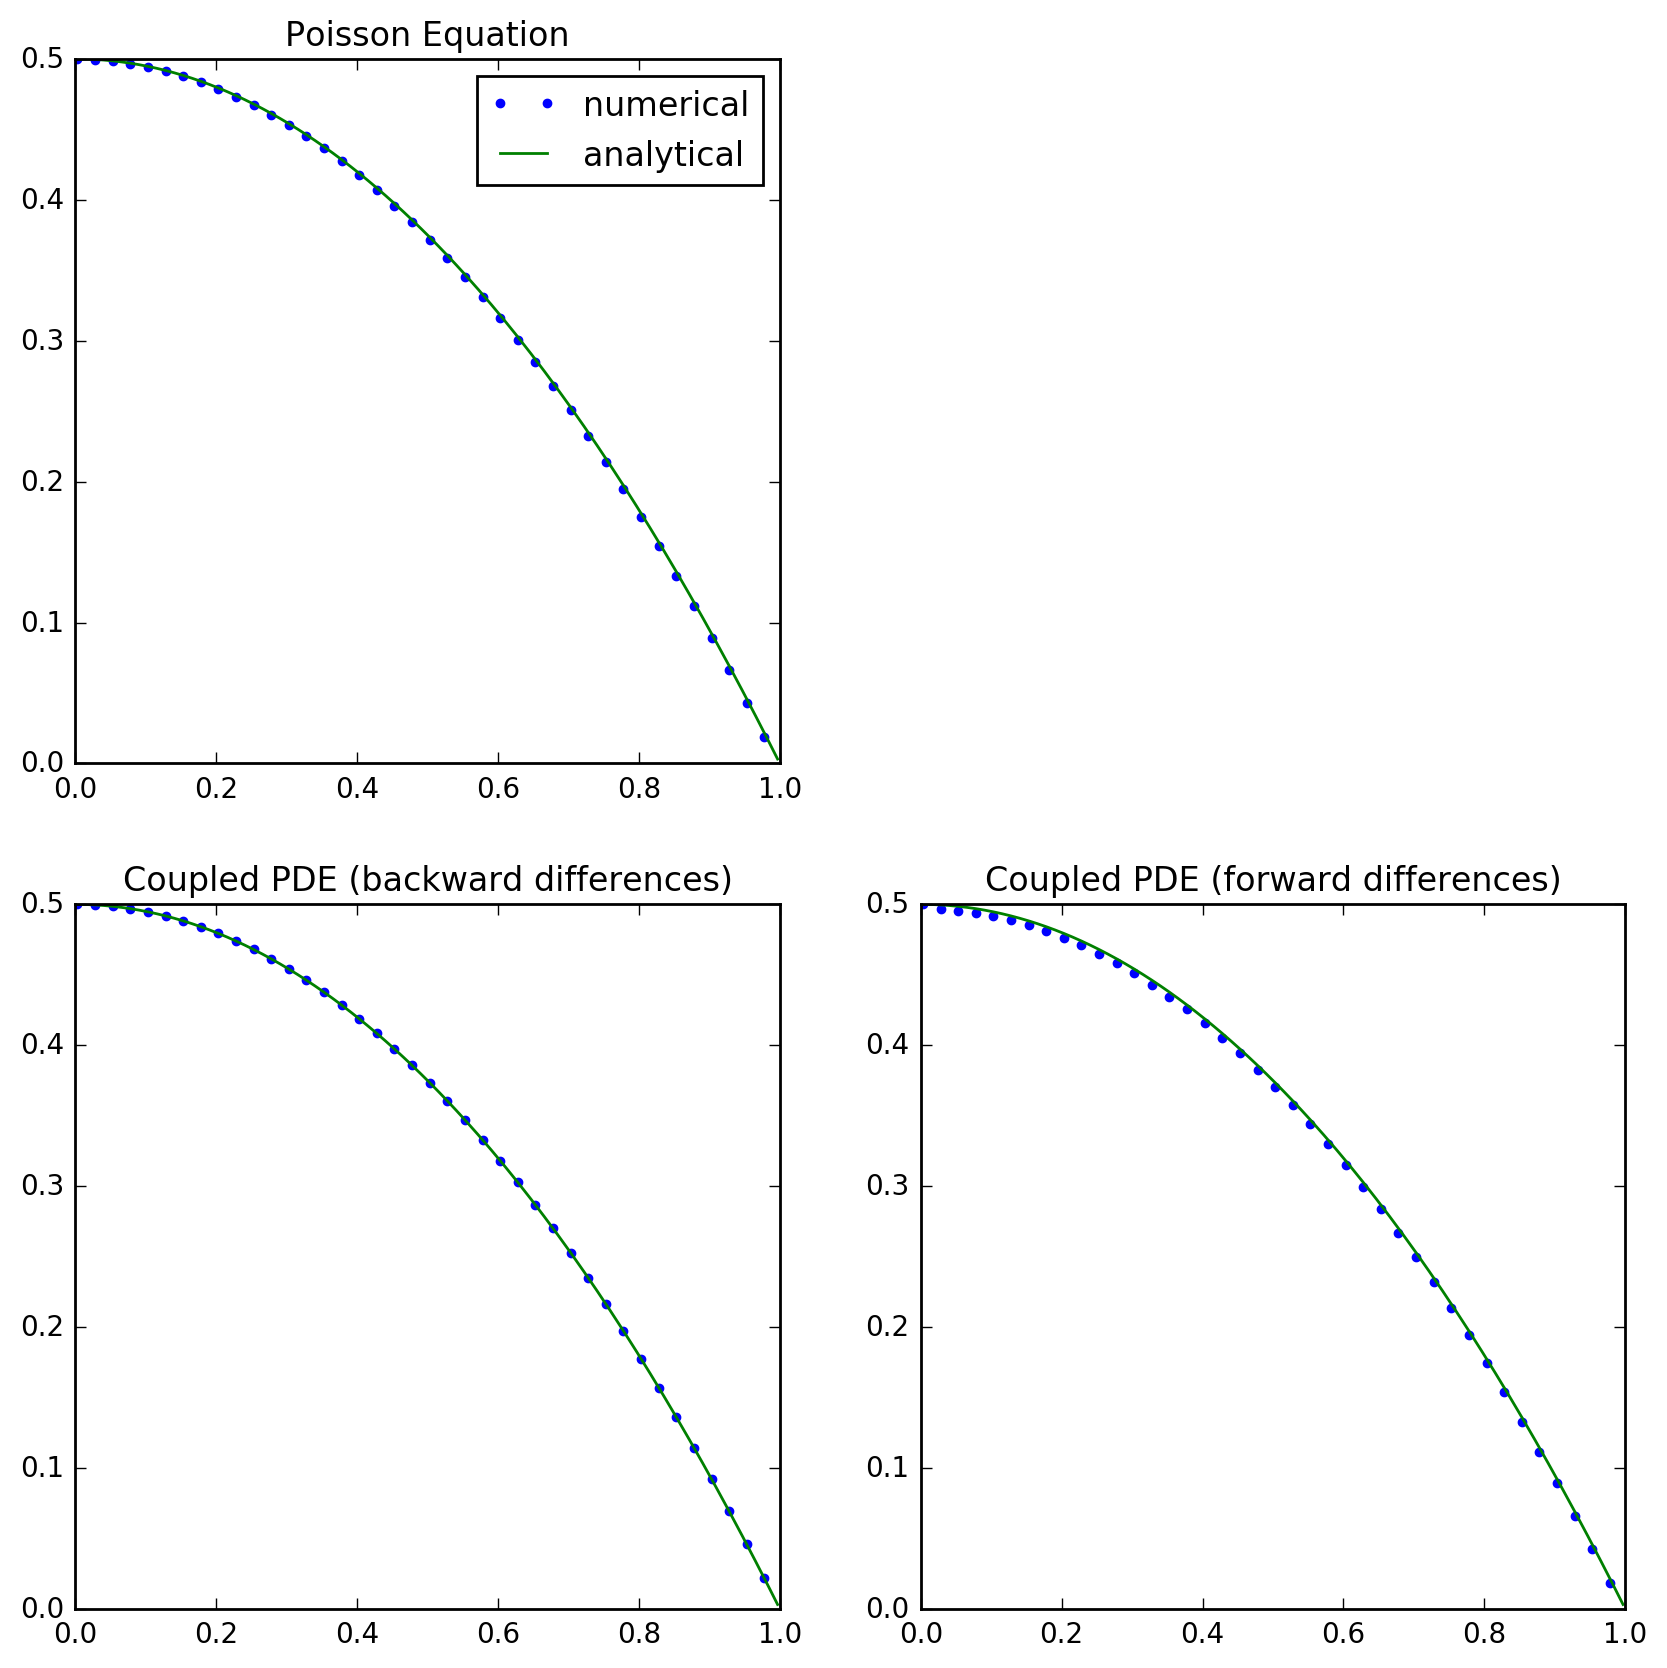

In [4]:
def phi_groundtruth( x ):
    return 0.5*(1-x*x)

def gradphi_groundtruth( x ):
    return -x

# setup problem -------------
Q = -np.ones((domain.res)) # RHS
phi_boundary = np.zeros((domain.res))
phi_boundary[0] = phi_groundtruth(domain.bound_min)
phi_boundary[domain.res-1] = phi_groundtruth(domain.bound_max)

E_boundary = np.zeros((domain.res))
E_boundary[0] = gradphi_groundtruth(domain.bound_min)
E_boundary[domain.res-1] = gradphi_groundtruth(domain.bound_max)

# solve -------------
phi_poisson = solve_poisson(domain, numIterations, Q, phi_boundary)
(phi_coupled_backward, E_backward) = solve_poisson_coupled(domain, numIterations, Q, phi_boundary, E_boundary)
# here we solve the same problem again, but use forward differencing scheme
(phi_coupled_forward, E_forward) = solve_poisson_coupled(domain, numIterations, Q, phi_boundary, E_boundary, False)


#plot results --------------
plt.figure(figsize=(10, 10))

plt.subplot(221)
ax = plt.gca()
plt.plot(domain_x[::4], phi_poisson[::4], label="numerical", linestyle = ' ', marker='.')
plt.plot(domain_x, domain.rasterize(phi_groundtruth), label="analytical", linestyle = '-')
plt.title("Poisson Equation")
plt.legend(loc='best')


plt.subplot(223)
ax = plt.gca()
plt.plot(domain_x[::4], phi_coupled_backward[::4], label="numerical solution", linestyle = ' ', marker='.')
plt.plot(domain_x, domain.rasterize(phi_groundtruth), label="analytical solution", linestyle = '-')
plt.title("Coupled PDE (backward differences)")
#plt.legend(loc='lower left')

plt.subplot(224)
ax = plt.gca()
plt.plot(domain_x[::4], phi_coupled_forward[::4], label="numerical solution", linestyle = ' ', marker='.')
plt.plot(domain_x, domain.rasterize(phi_groundtruth), label="analytical solution", linestyle = '-')
plt.title("Coupled PDE (forward differences)")

plt.show()

### Discussion

- **Results**
    - We see that solving the system of coupled PDEs results in the correct solution. This shows that we can either solve the Poisson equation (diffusion approximation) or a system of coupled PDEs ($P_1$ approximation) to arrive at the same solution.
    - By just looking at the plots, we note that the backward differences solution from the system of coupled PDEs appears to be more accurate than the solution from the Poisson equation and the solution from the system of coupled PDEs with forward differences.
    - The coupling between the two PDEs is actually very weak. We see, that the value of $\phi$ has no influence on the update of $E_i$. This would be different, once we add some additional terms (such as the absorption term) from the expanded RTE. Adding more terms and coefficients will make solving the $P_1$ system of coupled PDEs more difficult.

## Experiment: Solution for Point Source Problem

In this experiment, we will try to solve a point source problem where we have:

$$\nabla^2\phi = Q$$

with $Q$ being a signed delta distribution at the center of our simulation domain (which is $[0, 1]$):

$$Q=-\delta\left( x-0.5\right)$$



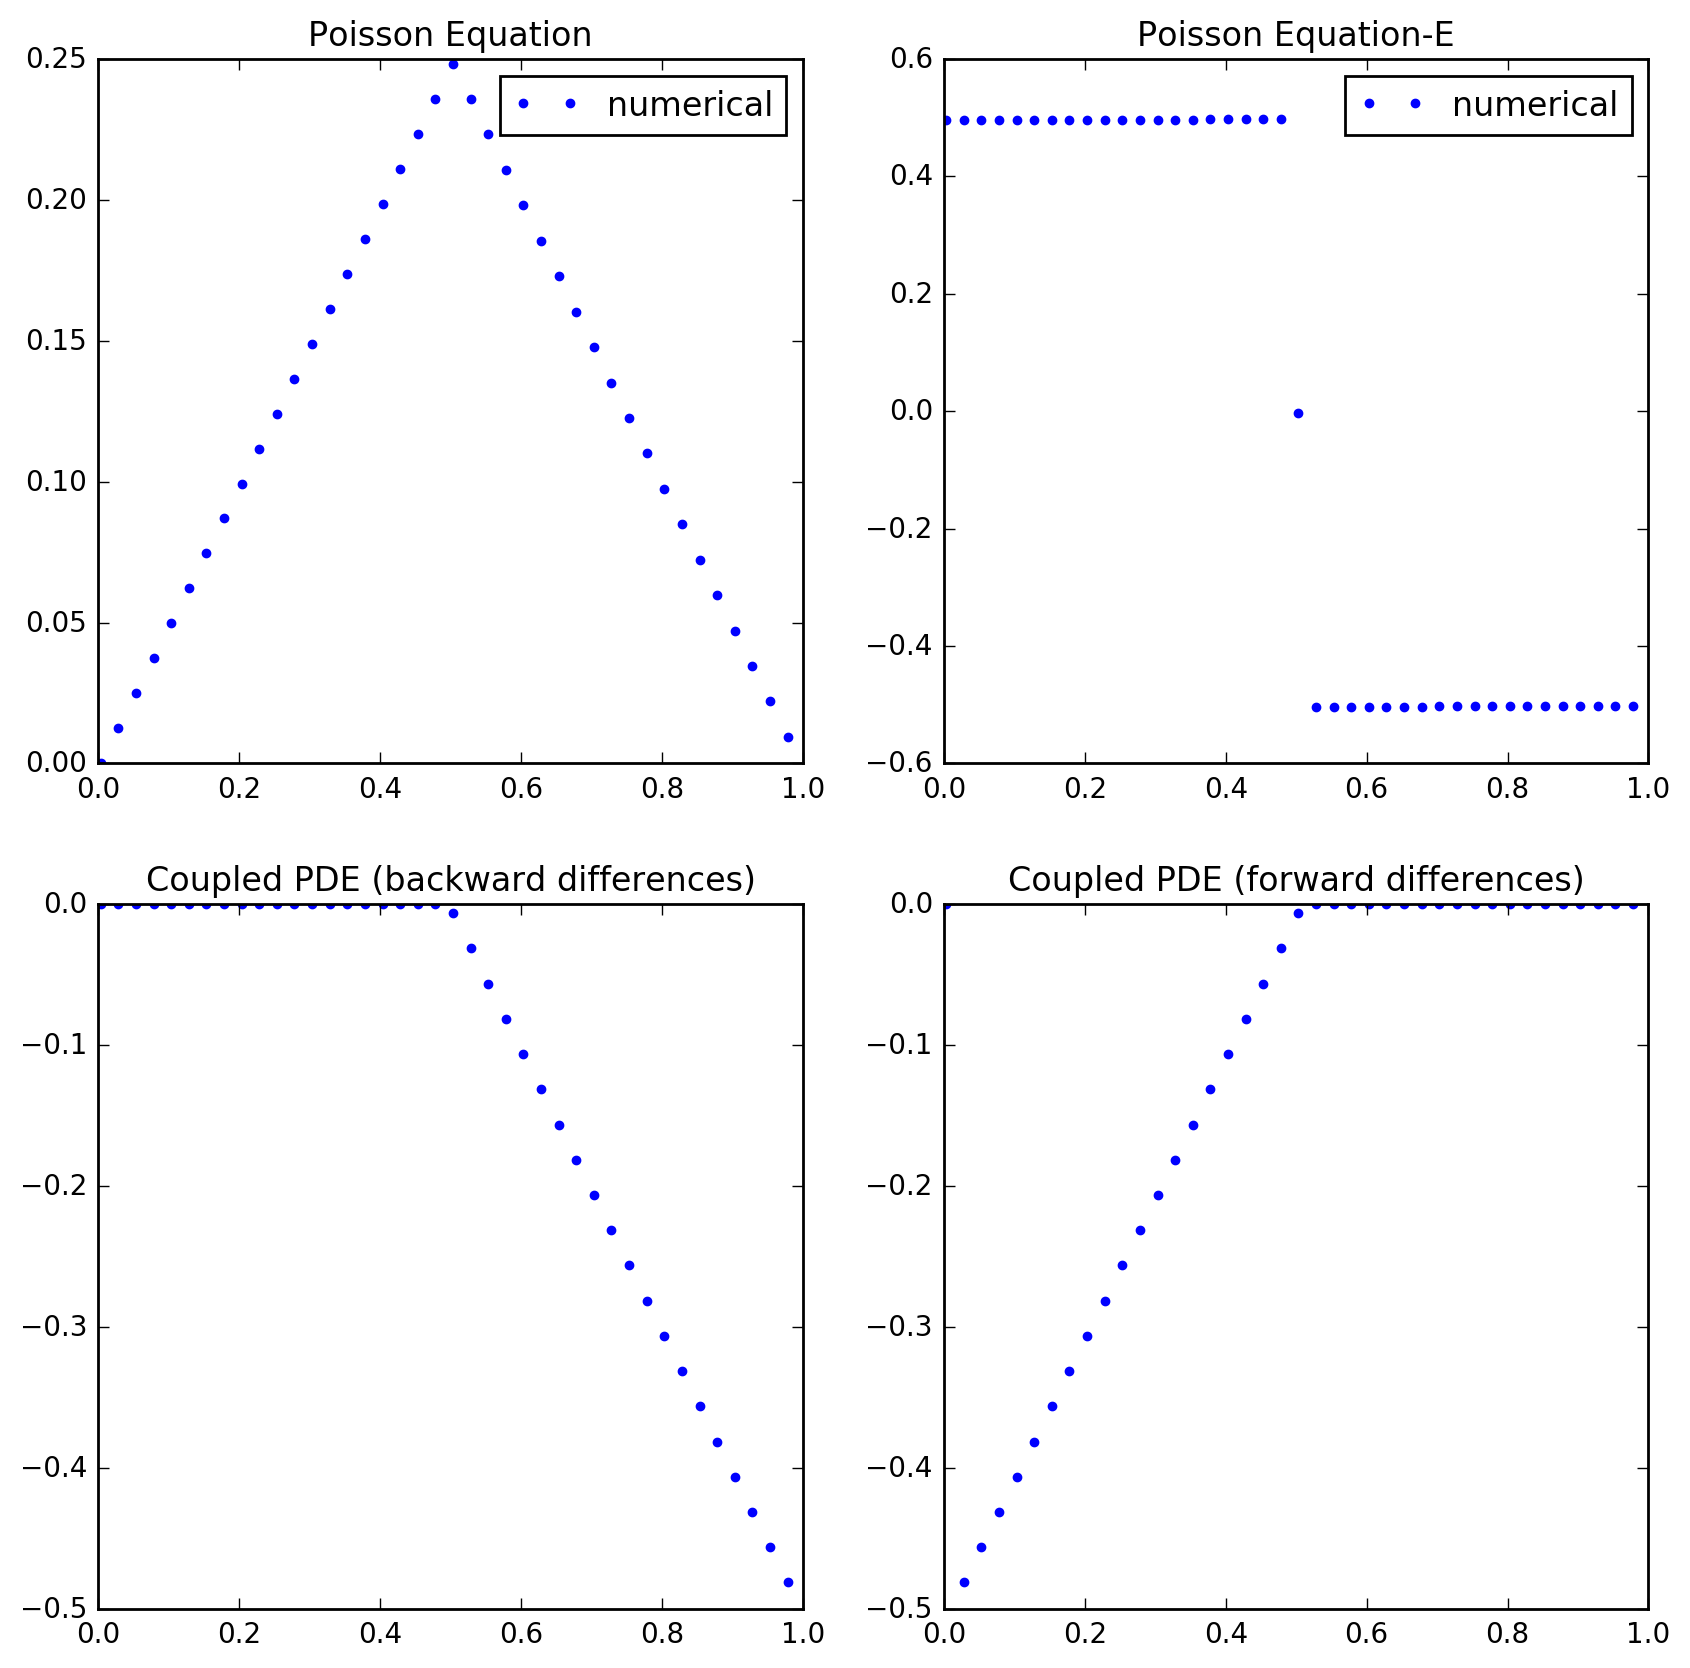

In [5]:
# setup problem -------------
Q = np.zeros((domain.res)) # RHS
pointsource_center_ls = 0.5
pointsource_center_ws = domain.localToWorld(pointsource_center_ls)
pointsource_voxel = domain.voxelToIndex(domain.localToVoxel(pointsource_center_ls))
Q[pointsource_voxel] = -1.0/(domain.h)

phi_boundary = np.zeros((domain.res))
E_boundary = np.zeros((domain.res))

# solve -------------
phi_poisson = solve_poisson(domain, numIterations, Q, phi_boundary)
(phi_forward, E_forward) = solve_poisson_coupled(domain, numIterations, Q, phi_boundary, E_boundary, False)
(phi_backward, E_backward) = solve_poisson_coupled(domain, numIterations, Q, phi_boundary, E_boundary, True)

#plot results --------------
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
ax = plt.gca()
plt.plot(domain_x[::4], phi_poisson[::4], label="numerical", linestyle = ' ', marker='.')
plt.title("Poisson Equation")
plt.legend(loc='best')

plt.subplot(222)
ax = plt.gca()
plt.plot(domain_x[::4], domain.gradient(phi_poisson)[::4], label="numerical", linestyle = ' ', marker='.')
plt.title("Poisson Equation-E")
plt.legend(loc='best')


plt.subplot(223)
ax = plt.gca()
plt.plot(domain_x[::4], phi_backward[::4], label="numerical", linestyle = ' ', marker='.')
plt.title("Coupled PDE (backward differences)")

plt.subplot(224)
ax = plt.gca()
plt.plot(domain_x[::4], phi_forward[::4], label="numerical", linestyle = ' ', marker='.')
plt.title("Coupled PDE (forward differences)")

plt.show()

### Discussion

- **Results**
    - The point source test reveals problems with the coupled PDE approach. Due to the use of single sided differences, information will not propagate in all directions. This problem didn't show up in the first experiment, because the solution was a pure upwind solution where the boundary conditions of $E$ would make sure that the information propagates correctly. I tried to experiment with an upwind difference scheme when solving the coupled PDEs without luck.
    - Is there a way to discretize the coupled PDEs using a central differencing scheme? Why is it not possible to derive a Gauss-Seidel update rule when using central differences?